In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import signac
import gsd
import freud
from scipy.stats import uniform
from scipy.optimize import curve_fit
from scipy.special import erf
from joblib import Parallel, delayed

import pandas as pd
import mdtraj




In [2]:
type_list = np.load("particle_types.npy")
poses = np.load("particle_positions.npy")
boxes = np.load("boxes.npy")
dips = np.load("induce_dipoles.npy")

perms = dips[:,:,3:6] * 10
inds = dips[:,:,:3] * 10

In [3]:
print(len(poses), len(boxes), len(dips))



500 500 500


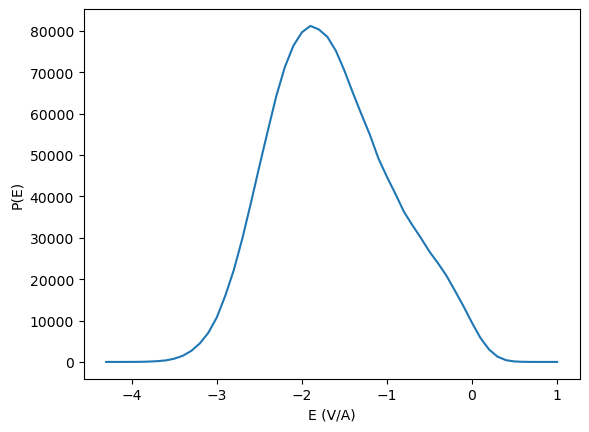

In [4]:
projs = [] # Electric fields, getting them from induced dipoles

for i in range(0, len(poses), 1):

    fbox = freud.box.Box.from_box(boxes[i])
    pos = poses[i]
    ind = inds[i]

    Opos =  pos[type_list == 0]
    Hpos =  pos[type_list == 1]
    C1pos = pos[type_list == 2]
    C2pos = pos[type_list == 3]
    H1pos = pos[type_list == 4]
    H2pos = pos[type_list == 5]    
    Hind = ind[type_list == 1]
    field = Hind / 0.496




    
    # Getting O to H vector
    vHpos = np.reshape(Hpos, [int(len(Hpos)/2), 2, 3])
    omat = np.copy(vHpos)        
    omat[:,0] = fbox.wrap(vHpos[:,0,:] - Opos)
    omat[:,1] = fbox.wrap(vHpos[:,1] - Opos)
    omat = np.reshape(omat, [len(Hpos), 3])
    omat = (omat.T / np.linalg.norm(omat, axis=1)).T
    
    proj = np.sum(field * omat, axis=1)
    projs.append(proj)
    
    

projs = np.array(projs)
    
un, co = np.unique(np.round(-14.4*projs, 1), return_counts=True)


plt.plot(un, co)
    
    
plt.xlabel("E (V/A)")
plt.ylabel("P(E)")


pair_amoeba_fields = np.reshape(projs, [len(projs), int(len(projs[0])/2), 2])



500
[16.71141675 -0.44519434  1.00081462]


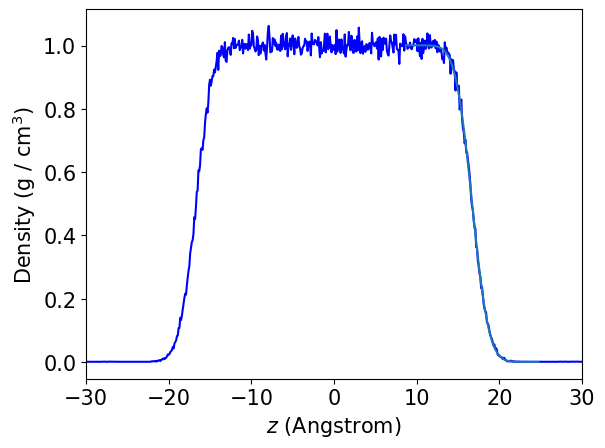

In [5]:
#Determining GDS

Oposes = []
Hposes = []
start = 0


for i in range(0, len(poses), 1):

    fbox = freud.box.Box.from_box(boxes[i])
    pos = poses[i]

    Opos =  pos[type_list == 0]
    Hpos =  pos[type_list == 1]
    
    Hpos = fbox.wrap(Hpos + np.array([0, 0, 10]))
    Opos = fbox.wrap(Opos + np.array([0, 0, 10]))
    C1pos = pos[type_list == 2]
    C1pos = pos[type_list == 3]
    H1pos = pos[type_list == 4]
    H2pos = pos[type_list == 5]
    
    
    Hpos = fbox.wrap(Hpos - [0, 0, np.average(Opos[:,2])])
    Opos = fbox.wrap(Opos - [0, 0, np.average(Opos[:,2])])
    
 

    Oposes.append(Opos)
    Hposes.append(Hpos)
    
Oposes = np.array(Oposes)
Hposes = np.array(Hposes)

water_function = lambda x, xo, scale, height: height*(erf(scale*(x - xo))/2 + 0.5)


boxW = boxes[0][0]**2 #Box area
start = 0 #Earliest Frame to include in data
tot = np.concatenate(Oposes[start:])
un, co = np.unique(np.round(tot[:,2], 1), return_counts=True)
dens = co/(len(Oposes) - start)/boxW/0.1/(1/18.02 * 6.022 * 10**23 / 10**24)
plt.plot(un, dens, c='Blue') # Density Distribution
plt.xlim(-30, 30)
       

print(len(Oposes))
rwater_var, rwater_cov = curve_fit(water_function,
                                   un[un > 0],
                                   dens[un > 0],
                                   [18, 1, 1],
                                   maxfev = int (2e5))

xx = np.linspace(rwater_var[0] - 8, rwater_var[0]+8)
yy = water_function(xx, *rwater_var)
plt.plot(xx, yy)

plt.ylabel('Density (g / cm$^3$)', fontsize=15)
plt.xlabel('$z$ (Angstrom)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
print(rwater_var)


In [6]:
Odisses = np.load("instant_interface/Odisses.npy", allow_pickle=True)[-500:]#Only using last 500 frames
Hdisses = np.load("instant_interface/Hdisses.npy", allow_pickle=True)[-500:]

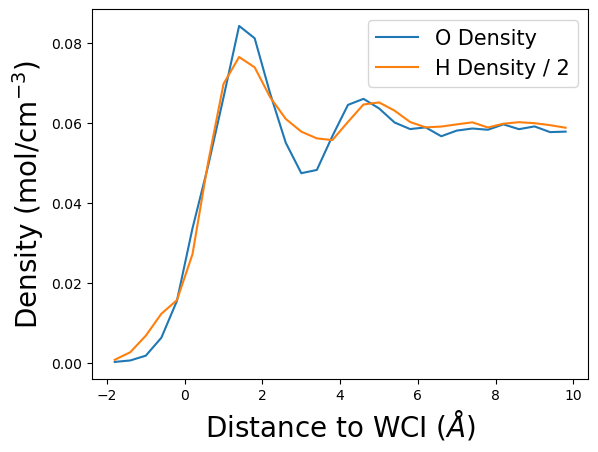

In [7]:
boxW = 36**2 #Area



coco, bins = np.histogram(np.concatenate(Odisses[10:]), range = (-2, 10.0), bins = 30)
binw = bins[1] - bins[0]
unco = bins[:-1] + binw/2
plt.plot(unco, coco/boxW/binw/len(Odisses[:])/(1 * 6.022 * 10**23 / 10**24), label='O Density') # O positions


coco, bins = np.histogram(np.concatenate(Hdisses[:]), range = (-2, 10.0), bins = 30)
binw = bins[1] - bins[0]
unco = bins[:-1] + binw/2
plt.plot(unco, coco/boxW/binw/len(Hdisses[:])/(1 * 6.022 * 10**23 / 10**24)/2, label='H Density / 2') # H positions



plt.xlabel("Distance to WCI ($\AA$)", size=20)
plt.ylabel("Density (mol/cm$^{-3}$)", size=20)

plt.legend(fontsize=15)





In [8]:
#Looking at hydrogen bonding





angles = [] # Angle formed with nearest water in OHO bond, used to distinguish free OHs
xangles = [] # Angle between OH stretch and interface, not used anywhere


for it in range(0, len(Oposes), 1):
    print(it)
    fbox = freud.box.Box.from_box(boxes[it])


    Opos = Oposes[it]
    Hpos = np.copy(Hposes[it])

    tHpos = np.reshape(Hpos, [int(len(Hpos)/2), 2, 3])
    keep_tHpos = np.copy(tHpos)
    tHpos[:,0,:] = fbox.wrap(tHpos[:,0,:] - Opos)
    tHpos[:,1,:] = fbox.wrap(tHpos[:,1,:] - Opos)

    cutofff = 90
    r_max = 3.5 # For every oxygen we find the neighboring ones within 3.5 A
    fbox = freud.box.Box.from_box(boxes[it])
    aq = freud.locality.AABBQuery(fbox, Opos)
    nlist = aq.query(Opos, {'r_max': r_max}).toNeighborList()


    Ovecs = fbox.wrap(Opos[nlist.point_indices] - Opos[nlist.query_point_indices])

    modquery = nlist.query_point_indices[np.sum(np.abs(Ovecs), axis=1) > 1e-8]
    Ovecs = Ovecs[np.sum(np.abs(Ovecs), axis=1) > 1e-8]


    angle = []
    xangle = []
    un = np.arange(0, len(Opos))
    for u in un[:]:
        u_H = tHpos[u]
        wh = np.where(modquery == u)[0]
        u_HO0 =  u_H[0]
        u_HO1 =  u_H[1]


        if len(wh) == 0: # Some oxygens have no oxygens within 3.5 angstrom. We say there angle is zero
            print('here') # Useful for debugging
            angle.append([Opos[u][2], 0, 0])
            xangle.append([Opos[u][2], u_HO0[2], u_HO1[2]])
            continue


        u_ovecs = Ovecs[wh] - u_H[0]
        u_ovecs = (u_ovecs.T / np.linalg.norm(u_ovecs, axis=1)).T
        u_HO0 = u_HO0 / np.linalg.norm(u_HO0)
        costheta0 = -np.sum(u_ovecs * u_HO0, axis=1)
        theta0 = np.arccos(costheta0)*180 / np.pi
        xtheta0 = np.arccos(u_HO0[2])*180 / np.pi



        u_ovecs = Ovecs[wh] - u_H[1]
        u_ovecs = (u_ovecs.T / np.linalg.norm(u_ovecs, axis=1)).T
        u_HO1 = u_HO1 / np.linalg.norm(u_HO1)
        costheta1 = -np.sum(u_ovecs * u_HO1, axis=1)
        theta1 = np.arccos(costheta1)*180 / np.pi
        xtheta1 = np.arccos(u_HO1[2])*180 / np.pi

        
        max0 = np.max(theta0)
        max1 = np.max(theta1)


        angle.append([Opos[u][2], max0, max1])
        xangle.append([Opos[u][2], u_HO0[2], u_HO1[2]])



        #print(u_ovecs)


    angles.append(angle)
    xangles.append(xangle)
        #break

    
angles35 = np.array(angles)
xangles = np.array(xangles)






0
1
2
3
4
5
6
7
8
9
10
11
12
here
13
14
15
16
17
here
18
here
19
20
21
here
22
here
23
24
here
25
26
27
28
29
30
31
here
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
here
54
here
55
here
56
here
57
here
58
here
59
here
60
here
61
62
63
here
64
65
66
67
68
69
here
70
71
72
73
74
75
76
77
78
79
80
81
82
here
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
here
122
123
124
125
126
127
128
129
130
131
132
133
here
134
here
135
here
136
here
137
here
138
here
139
here
140
here
141
here
142
here
143
144
145
146
147
148
149
here
150
151
152
153
154
155
156
157
158
159
160
161
162
here
163
164
165
166
167
168
169
170
171
172
173
here
174
here
175
176
177
178
179
180
here
181
182
183
184
185
here
186
187
188
189
here
190
here
191
192
here
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229


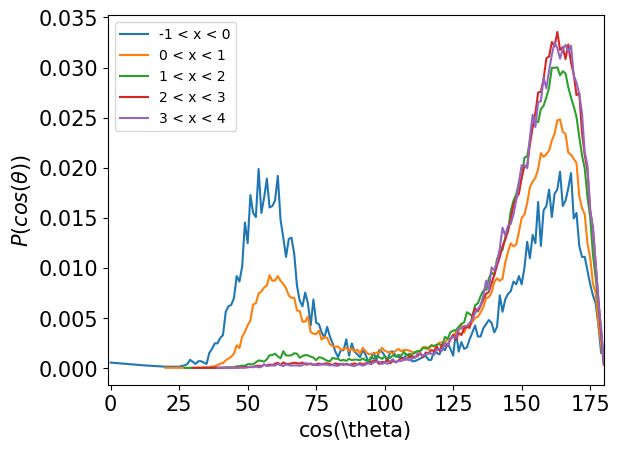

In [9]:

limits = [-1, 0, 1, 2, 3]
allangles = np.concatenate(angles35[:,:,1:])
Opos = np.concatenate(angles35[:,:,0])
alli = np.concatenate(Odisses[:])



allangles = allangles[Opos > 0]

for limit in limits:
    wh = np.where((alli > limit) * (alli < limit + 1.0))
    tallangles = allangles[wh]
    tallangles = np.concatenate(tallangles)

    un, co = np.unique(np.round(tallangles, 0), return_counts=True)
    binw = un[1] - un[0]
    plt.plot(un, co/np.sum(co), label = '{} < x < {}'.format(limit, limit+1))
    

plt.legend()    
plt.xlabel("cos(\\theta)", size=15)
plt.ylabel("$P(cos(\\theta))$", size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(-1, 180)
#plt.ylim(0, 0.00025)
plt.show()

In [10]:
#Computing Tetrahedral Order Parameter q4

q4s = []

for it in range(0, len(Oposes), 1):
    #print(it)
    Opos = Oposes[it]
    fbox = freud.box.Box.from_box(boxes[it])
    #print(Opos)
    aq = freud.locality.AABBQuery(fbox, Opos)
    nn = 4
    nlist = aq.query(Opos, {'num_neighbors': nn+1}).toNeighborList()


    Ovecs = fbox.wrap(Opos[nlist.point_indices] - Opos[nlist.query_point_indices])


    Ovecs = Ovecs[np.sum(np.abs(Ovecs), axis=1) > 1e-8]
    Onorm = np.linalg.norm(Ovecs, axis=1)


    Ovecs = (Ovecs.T/np.linalg.norm(Ovecs, axis=1)).T
    Ovecs = np.reshape(Ovecs, [int(len(Ovecs)/nn), nn, 3])
    Onorm = np.reshape(Onorm, [int(len(Onorm)/nn), nn])
    Onorm = np.sort(Onorm, axis=1)

    angles = []

    for j in range(nn-1):
        for k in range(j+1, nn):
            angles.append(np.sum(Ovecs[:,j]*Ovecs[:,k], axis=1))

    angles = np.asarray(angles)
    #print(len(angles), len(angles[0]))
    e_ang = np.sum((angles + 1/3)**2, axis=0)

    q4 = np.array([1 - 3/8*e_ang, Onorm[:,0], Onorm[:,1], Onorm[:,2], Onorm[:,3]]).T
    q4s.append(q4)

    print(it)
    
q4s = np.array(q4s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 [Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.7000000000000001, '0.7')])

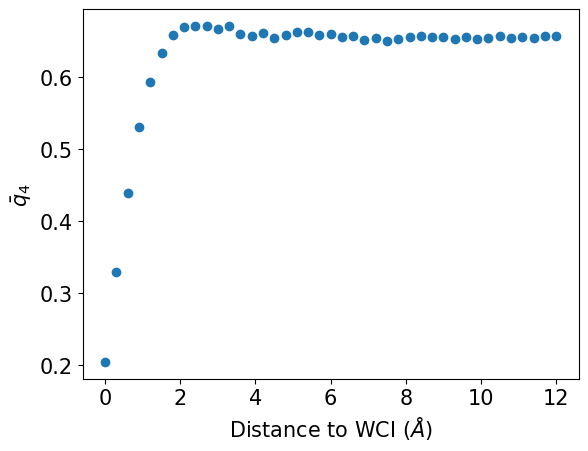

In [11]:
#Plotting it as a function of distance to WCI

limits = np.linspace(0, 12, 41)
bound = limits[1] - limits[0]

allqs = np.concatenate(q4s) # All order parameters
Opos = np.concatenate(angles35[:,:,0])
alli = np.concatenate(Odisses[:])

allqs = allqs[Opos > 0] # We only computed interfacial distances for waters with Oxygens whose z > 0

q4points = []

for limit in limits:
    wh = np.where((alli > limit) * (alli < limit + bound))
    tallqs = allqs[wh]
    tallqs = tallqs[:,0][tallqs[:,4] < 3.5]
    un, co = np.unique(np.round(tallqs, 2), return_counts=True)
    binw = un[1] - un[0]
    avg = np.average(tallqs)
    q4points.append([limit, avg])


q4points = np.array(q4points)
plt.scatter(q4points[:,0], q4points[:,1])

    
#plt.ylim(0, 0.002) 
plt.xlabel('Distance to WCI ($\AA$)', size=15)
plt.ylabel('$\\bar{q}_4}$', size=15)
plt.xticks(size=15)
plt.yticks(size=15)



In [12]:
# Computing q3 Not given in paper

q3s = []

for it in range(0, len(Oposes), 1):
    #print(it)
    Opos = Oposes[it]
    fbox = freud.box.Box.from_box(boxes[it])
    #print(Opos)
    aq = freud.locality.AABBQuery(fbox, Opos)
    nn = 3
    nlist = aq.query(Opos, {'num_neighbors': nn+1}).toNeighborList()
    Ovecs = fbox.wrap(Opos[nlist.point_indices] - Opos[nlist.query_point_indices])
    
    Ovecs = Ovecs[np.sum(np.abs(Ovecs), axis=1) > 1e-8]
    Onorm = np.linalg.norm(Ovecs, axis=1)

    Ovecs = (Ovecs.T/np.linalg.norm(Ovecs, axis=1)).T
    Ovecs = np.reshape(Ovecs, [int(len(Ovecs)/nn), nn, 3])
    Onorm = np.reshape(Onorm, [int(len(Onorm)/nn), nn])
    Onorm = np.sort(Onorm, axis=1)

    angles = []

    for j in range(nn-1):
        for k in range(j+1, nn):
            angles.append(np.sum(Ovecs[:,j]*Ovecs[:,k], axis=1))

    angles = np.asarray(angles)
    #print(len(angles), len(angles[0]))
    e_ang = np.sum((angles + 1/3)**2, axis=0)

    q3 = np.array([1 - 6/8*e_ang, Onorm[:,0], Onorm[:,1], Onorm[:,2]]).T
    q3s.append(q3)

    print(it)
    
q3s = np.array(q3s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

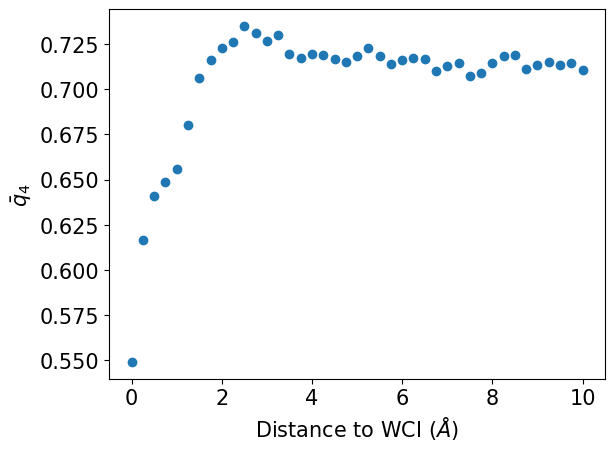

In [13]:
#Computing q3 as a function of distance to the interface

limits = np.linspace(0, 10, 41)
bound = limits[1] - limits[0]

allqs = np.concatenate(q3s)
Opos = np.concatenate(angles35[:,:,0])
alli = np.concatenate(Odisses[:])


allqs = allqs[Opos > 0]  # We only computed interfacial distances for waters with Oxygens whose z > 0

q3points = []

for limit in limits:
    wh = np.where((alli > limit) * (alli < limit + bound))
    tallqs = allqs[wh]
    tallqs = tallqs[:,0][tallqs[:,3] < 3.5]
    un, co = np.unique(np.round(tallqs, 2), return_counts=True)
    binw = un[1] - un[0]
    avg = np.average(tallqs)
    q3points.append([limit, avg])


q3points = np.array(q3points)
plt.scatter(q3points[:,0], q3points[:,1])

    
plt.xlabel('Distance to WCI ($\AA$)', size=15)
plt.ylabel('$\\bar{q}_4}$', size=15)
plt.xticks(size=15)
plt.yticks(size=15)

plt.show()